In [20]:
#| code-fold : true
#| output : false
#| code-summary : 'imports'

# here i am importing probably more than what we need.
# #region imports
from IPython import get_ipython

# noinspection PyBroadException
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass


# noinspection PyUnresolvedReferences
import glob
# noinspection PyUnresolvedReferences
import os
# noinspection PyUnresolvedReferences
import pprint
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import matplotlib as mpl
# noinspection PyUnresolvedReferences
import matplotlib.colors
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import xarray as xr
# noinspection PyUnresolvedReferences
#import bnn_tools.bnn_array

plt.style.use('default')
xr.set_options(
    display_expand_data = False,
    display_expand_data_vars = True,
    display_max_rows = 10,
    display_style = 'html',
    display_width = 80,
    display_expand_attrs = False
);
#endregion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## xarray intro

This notebook provides a brief introduction to using xarray with particle number size distributions,
specifically how to open and plot the files provided for the exercise.

*Disclaimer:* I used ChatGPT to comment the code. I reviewed all comments to ensure they are informative and convey the intended meaning.
When necessary, I modified them to accurately reflect the correct information.

Furthermore, I generally code using the "method chaining" paradigm, which makes code much more readable in both Pandas and Xarray (in my opinion). You can read more about it [here](https://tomaugspurger.net/posts/method-chaining/).



## Open datasets

In [2]:
# Define the absolute path to your data directory.
# Set it to an empty string ('') if your data is in the same folder as the script.
data_dir = ('/Users/aliaga/Documents/Work_DA/PostDocSU/'
            'ACP-teaching/ACP-data-exploration/'
            'ACP_25_project/data/')

# Construct full paths to the dataset files
p1 = data_dir + 'hourly_data_chc_alto_acp.nc'
# Path to hourly data

p2 = data_dir + 'particle_number_size_dist_ACP.nc'
# Path to particle number size distribution data

# Open the datasets using xarray
ds1 = xr.open_dataset(p1)  # Load the first dataset
ds2 = xr.open_dataset(p2)  # Load the second dataset

## Select id

The PNSD file contains several IDs, each representing a different way of combining data from the NAIS and SMPS instruments. For this exercise, we will focus only on the ‘10xnais_ion_neutral_smps’ ID. This ID means:

- NAIS naturrally charged particles between 2-4nm x10
    - notice the multiplication by 10. This is because charged particle are in general and by definition less abundant than neutral particles
- NAIS neutral particles between 4–15 nm
- SMPS measures particles between 15–440 nm



In [4]:
#print all available ids
ds2.id.to_series().reset_index(drop=True)

0                      ion_neg
1                      ion_pos
2    nais_ion_neg_neutral_smps
3        nais_ion_neutral_smps
4            nais_neutral_smps
5                  neutral_neg
6                  neutral_pos
7                         smps
8     10xnais_ion_neutral_smps
Name: id, dtype: object

For counting the total number of particles, always use **nais_neutral_smps** to avoid altering the particle count by multiplying by 10 or using a specific range.

**Summary:**

- Use **10xnais_ion_neutral_smps** for **plotting**
- Use **nais_neutral_smps** for **calculations**

In [10]:
ds2

<xarray.Dataset> Size: 91MB
Dimensions:  (loc: 2, id: 9, Dp: 59, time: 10656)
Coordinates:
  * loc      (loc) <U4 32B 'alto' 'chc'
  * id       (id) <U25 900B 'ion_neg' 'ion_pos' ... '10xnais_ion_neutral_smps'
  * Dp       (Dp) float64 472B 7.943e-10 8.913e-10 1e-09 ... 5.623e-07 6.31e-07
  * time     (time) datetime64[ns] 85kB 2018-03-19 ... 2018-05-31T23:50:00
    hr_t     (time) timedelta64[ns] 85kB ...
    hour     (time) float64 85kB ...
Data variables:
    dndlDp   (id, loc, Dp, time) float64 91MB ...

In [13]:
# Select data from ds2 for the specified ID
Id = '10xnais_ion_neutral_smps'

selected_data = (
    ds2
    .loc[{'id': Id}]  # Filter dataset by the given ID
)

# Display the selected data
selected_data

<xarray.Dataset> Size: 10MB
Dimensions:  (loc: 2, Dp: 59, time: 10656)
Coordinates:
  * loc      (loc) <U4 32B 'alto' 'chc'
    id       <U25 100B 'nais_neutral_smps'
  * Dp       (Dp) float64 472B 7.943e-10 8.913e-10 1e-09 ... 5.623e-07 6.31e-07
  * time     (time) datetime64[ns] 85kB 2018-03-19 ... 2018-05-31T23:50:00
    hr_t     (time) timedelta64[ns] 85kB ...
    hour     (time) float64 85kB ...
Data variables:
    dndlDp   (loc, Dp, time) float64 10MB ...

We are also only using 1 variable (dndlDp) in this dataset. So it is better to call the variable which collapses the dataset into a dataarray:

In [14]:
# Define the ID and variable to select
Id = '10xnais_ion_neutral_smps'
Var = 'dndlDp'

# Select the specified variable from the dataset filtered by ID
selected_var = (
    ds2
    .loc[{'id': Id}]  # Filter dataset by the given ID
    [Var]  # Select the variable
)

# Display the selected variable
selected_var

<xarray.DataArray 'dndlDp' (loc: 2, Dp: 59, time: 10656)> Size: 10MB
[1257408 values with dtype=float64]
Coordinates:
  * loc      (loc) <U4 32B 'alto' 'chc'
    id       <U25 100B 'nais_neutral_smps'
  * Dp       (Dp) float64 472B 7.943e-10 8.913e-10 1e-09 ... 5.623e-07 6.31e-07
  * time     (time) datetime64[ns] 85kB 2018-03-19 ... 2018-05-31T23:50:00
    hr_t     (time) timedelta64[ns] 85kB ...
    hour     (time) float64 85kB ...
Attributes: (3)

## Plot a particle number size distribution

Plotting a PNSD is not entirely intuitive. You can use the **matplotlib** framework directly, but **xarray** sometimes makes it easier.

Example:
Try commenting out some lines to see their effect.

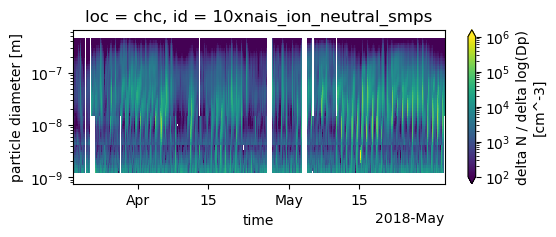

In [24]:
#| label: fig-pnsd-chc
#| fig-cap: "Particle number size distribution timeseries over CHC"

# Define selection parameters
Id = '10xnais_ion_neutral_smps'  # Instrument ID
Var = 'dndlDp'  # Variable to plot
Loc = 'chc'  # Location

# Select and plot the data
(
    ds2
    .loc[{'id': Id}]  # Filter by instrument ID
    .loc[{'loc': Loc}]  # Filter by location
    [Var]  # Select the variable
    .plot(
        x='time',  # Set x-axis to time
        y='Dp',  # Set y-axis to particle diameter
        norm=mpl.colors.LogNorm(vmin=1e2, vmax=1e6),
        # Logarithmic color scale normalization
        cmap='viridis',  # Use the Viridis colormap
        yscale='log',  # Logarithmic y-axis scale
        size=2,  # Adjust figure size
        aspect=3  # Adjust aspect ratio
    )
)

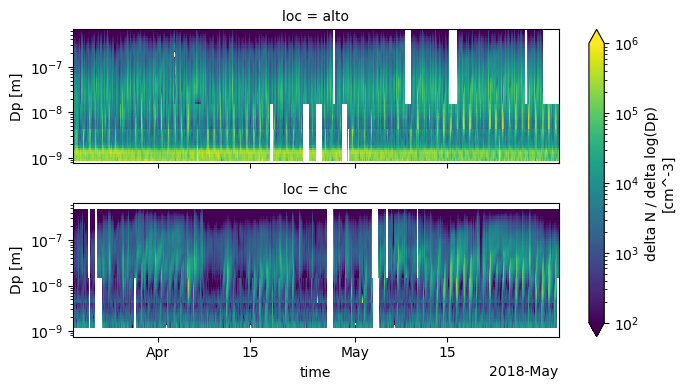

In [125]:
#| label: fig-pnsd-chc-eac
#| fig-cap: "Particle number size distribution timeseries over CHC and EAC."

# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier (currently not used)

(
    ds2
    .loc[{'id': Id}]  # Select data based on the given ID
    [Var]  # Extract the variable of interest
    .rename({'Dp':'Dp [m]'}) # rename for the ylabel
    .plot(
        x='time',  # Set x-axis as time
        y='Dp [m]',  # Set y-axis as particle diameter
        norm=mpl.colors.LogNorm(vmin=1e2, vmax=1e6),
        # Apply logarithmic normalization for color scale
        cmap='viridis',
        # Use the 'viridis' colormap for better visibility
        yscale='log',  # Set y-axis to logarithmic scale
        size=2,  # Adjust panel height for better readability
        aspect=3,  # Set aspect ratio for better visualization
        row='loc'  # Create separate plots for each location
    )
);

## Median / mean over time

Here, we calculate and plot the overall
median (@fig-pnsd-chc-median, @fig-pnsd-chc-median1) and
mean (@fig-mean) PNSD.
First, we analyze CHC alone, followed by a combined analysis of CHC and EAC.

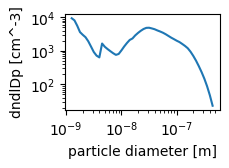

In [26]:
#| label: fig-pnsd-chc-median
#| fig-cap: "Median particle size distribution over CHC"

# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier

(
    ds2
    .loc[{'id': Id}]   # Select data based on the given ID
    .loc[{'loc': Loc}]  # Filter data for the specified location
    [Var]               # Extract the variable of interest
    .median('time')     # Compute the median over the time dimension
    .rename(Var + ' [cm^-3]') # rename for ylable
    .reset_coords(drop=True) # so that the title is not messy
    .plot(              # Plot the data
        yscale='log',   # Set y-axis to logarithmic scale
        xscale='log'    # Set x-axis to logarithmic scale
    )
)

f:plt.Figure = plt.gcf()
_s = 2;f.set_size_inches(_s,_s/1.6)

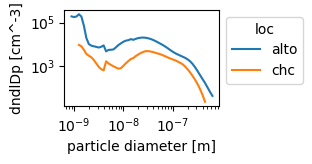

In [22]:
#| label: fig-pnsd-chc-median1
#| fig-cap: "Median over time."
# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier (currently not used)

(
    ds2
    .loc[{'id': Id}]   # Select data based on the given ID
    # .loc[{'loc': Loc}]  # Location filtering is commented out
    [Var]               # Extract the variable of interest
    .median('time')     # Compute the median over the time dimension
    .rename(Var + ' [cm^-3]') # rename for ylable
    .reset_coords(drop=True) # so that the title is not messy
    .plot(              # Plot the data
        yscale='log',   # Set y-axis to logarithmic scale
        xscale='log',   # Set x-axis to logarithmic scale
        hue='loc'       # Differentiate locations using color
    )
);
ax:plt.Axes = plt.gca()

ax.get_legend().set_bbox_to_anchor([1,1])

f:plt.Figure = plt.gcf()
_s = 2;f.set_size_inches(_s,_s/1.6)

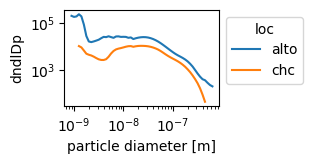

In [25]:
#| label: fig-mean
#| fig-cap: "Mean over time."

# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier (currently not used)

(
    ds2
    .loc[{'id': Id}]   # Select data based on the given ID
        # .loc[{'loc': Loc}]  # Location filtering is commented out
    [Var]               # Extract the variable of interest
    .mean('time')     # Compute the mean over the time dimension
    .reset_coords(drop=True) # so that the title is not messy
    .plot(              # Plot the data
        yscale='log',   # Set y-axis to logarithmic scale
        xscale='log',   # Set x-axis to logarithmic scale
        hue='loc'       # Differentiate locations using color
    )
);
ax:plt.Axes = plt.gca()
ax.get_legend().set_bbox_to_anchor([1,1])
f:plt.Figure = plt.gcf()
_s = 2;f.set_size_inches(_s,_s/1.6)

## Median /mean at specific time

We can also take the median at specific times during the day.
For example at 5AM (before sunrise) and noon(peak irradiance) which are shown in @fig-pnsd-hour-loc.

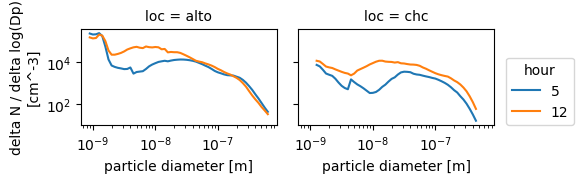

In [34]:
#| label: fig-pnsd-hour-loc
#| fig-cap: "Median Particle number size distribution timeseries over CHC and EAC color coded by hour."

# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier (currently not used)

(
    ds2
    .loc[{'id': Id}]   # Select data based on the given ID
    [Var]               # Extract the variable of interest

    # Create an 'hour' coordinate from time
    .assign_coords({'hour': lambda d: d['time'].dt.hour})
    .groupby('hour').median()
    # Compute the median for each hour group
    .loc[{'hour': [5, 12]}]
    # Select data for specific hours (5 AM and 12 PM)

    .plot(
        yscale='log',   # Set y-axis to logarithmic scale
        xscale='log',   # Set x-axis to logarithmic scale
        hue='hour',     # Differentiate data by hour using color
        col='loc',
        # Create separate plots for each location

        size = 2
    )
);

f:plt.Figure = plt.gcf()
_s = 6;f.set_size_inches(_s,_s/3.2)

## Select a day

We can also select a specific
day @fig-npf-day
or a time range @fig-npf-days

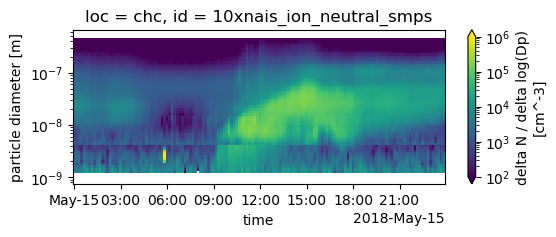

In [133]:
#| label: fig-npf-day
#| fig-cap: "Particle number size distribution timeseries over CHC for 2018-05-15."


# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier
Day = '2018-05-15'  # Specific day for filtering

(
    ds2
    .loc[{'id': Id}]  # Select data based on the given ID
    .loc[{'loc': Loc}]  # Filter data for the specified location
    .loc[{'time': Day}]  # Select data for the specified day
    [Var]  # Extract the variable of interest
    .plot(
        x='time',  # Set x-axis as time
        y='Dp',  # Set y-axis as particle diameter
        norm=mpl.colors.LogNorm(vmin=1e2, vmax=1e6),
        # Apply logarithmic normalization for color scale
        cmap='viridis',
        # Use the 'viridis' colormap for better visibility
        yscale='log',  # Set y-axis to logarithmic scale
        size=2,  # Adjust panel height for better readability
        aspect=3  # Set aspect ratio for better visualization
    )
);

## Select a time range

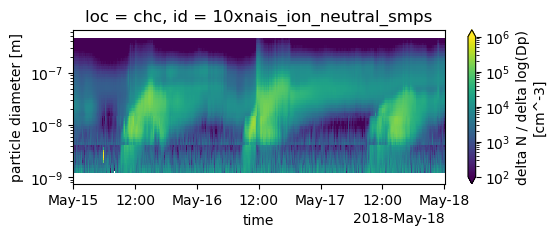

In [134]:
#| label: fig-npf-days
#| fig-cap: "Particle number size distribution timeseries over CHC from 2018-05-15 to 2018-05-18 00:00."

# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier
Date1 = '2018-05-15 00:00'  # Specific day for filtering
Date2 = '2018-05-18 00:00'

(
    ds2
    .loc[{'id': Id}]  # Select data based on the given ID
    .loc[{'loc': Loc}]  # Filter data for the specified location
    .loc[{'time': slice(Date1,Date2)}]
        # Select data for the specified date range
    [Var]  # Extract the variable of interest
    .plot(
        x='time',  # Set x-axis as time
        y='Dp',  # Set y-axis as particle diameter
        norm=mpl.colors.LogNorm(vmin=1e2, vmax=1e6),
        # Apply logarithmic normalization for color scale
        cmap='viridis',
        # Use the 'viridis' colormap for better visibility
        yscale='log',  # Set y-axis to logarithmic scale
        size=2,  # Adjust marker size for better readability
        aspect=3  # Set aspect ratio for better visualization
    )
);

## Select a size range

We can also select a specific size range (@fig-sr).

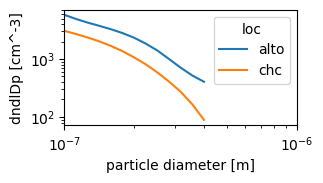

In [42]:
#| label: fig-sr
#| fig-cap: "Median over time in the size range from 100 to 400nm."

# Define parameters for selection
Id = '10xnais_ion_neutral_smps'  # Data identifier for plotting
Var = 'dndlDp'  # Variable of interest
Loc = 'chc'  # Location identifier (currently not used)
S1 = 100e-9
S2 = 400e-9

(
    ds2
    .loc[{'id': Id}]   # Select data based on the given ID
    .loc[{'Dp': slice(S1,S2)}]  # Select a size range
    [Var]               # Extract the variable of interest
    .mean('time')     # Compute the mean over the time dimension
    .rename(Var + ' [cm^-3]') # rename for ylable
    .reset_coords(drop=True) # so that the title is not messy
    .plot(              # Plot the data
        yscale='log',   # Set y-axis to logarithmic scale
        xscale='log',   # Set x-axis to logarithmic scale
        hue='loc'       # Differentiate locations using color
    )
);

ax = plt.gca()
#send legend to the size
ax.get_legend().set_bbox_to_anchor([1,1])

ax.set_xlim(1e-7,1e-6)
f:plt.Figure = plt.gcf()
_s = 3;f.set_size_inches(_s,_s/2)

## Plotting distributions

In [59]:
ds1

<xarray.Dataset> Size: 881kB
Dimensions:      (loc: 2, time: 1776)
Coordinates:
  * loc          (loc) <U4 32B 'alto' 'chc'
  * time         (time) datetime64[ns] 14kB 2018-03-19 ... 2018-05-31T23:00:00
    hr           (time) int64 14kB ...
Data variables: (10/30)
    Ammonium     (loc, time) float64 28kB ...
    Nitrate      (loc, time) float64 28kB ...
    Organics     (loc, time) float64 28kB ...
    Sulfate      (loc, time) float64 28kB ...
    eBC          (loc, time) float64 28kB ...
    ...           ...
    N_13_40      (loc, time) float64 28kB ...
    N_40_100     (loc, time) float64 28kB ...
    N_4_440      (loc, time) float64 28kB ...
    N_4_7        (loc, time) float64 28kB ...
    N_7_13       (loc, time) float64 28kB ...

Some variables follow a logarithmic distribution, such as eBC or total particle number concentrations. In such cases:

- Use the log of the value for plotting and calculations.
- Alternatively, use a logarithmic y-scale when plotting.
- For aggregation, use the median rather than the mean.

One way to check this is by plotting their histograms or probability distribution functions. For example, below (@fig-dist-lin), I do this for eBC.

In the first histogram, most values are concentrated in the first bin, with very few spread across larger sizes, making it hard to interpret. However, if we take the logarithm and plot the histogram again (@fig-dist-log), we often see a distribution that better resembles a Gaussian. This is a strong indicator that the variable follows a logarithmic distribution.

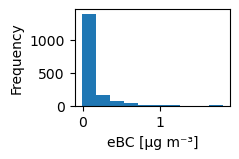

In [43]:
#| label: fig-dist-lin
#| fig-cap: "Linear eBC hisogram."
(
    ds1['eBC']  # Select the 'eBC' variable from the dataset
    .loc[{'loc': 'chc'}]  # Filter data for location 'chc'
    .to_series()  # Convert to Pandas Series for easier plotting
    .plot.hist()  # Plot histogram of the raw eBC values
)

# Get current axis and set x-axis label
ax: plt.Axes = plt.gca()
ax.set_xlabel('eBC [µg m⁻³]');
# Label the x-axis with proper units

f:plt.Figure = plt.gcf()
_s = 2;f.set_size_inches(_s,_s/1.6)

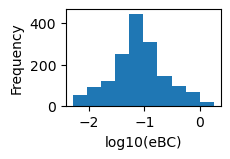

In [63]:
#| label: fig-dist-log
#| fig-cap: "Logaritmic eBC hisogram."

(
    ds1['eBC']  # Select the 'eBC' variable from the dataset
    .loc[{'loc': 'chc'}]  # Filter data for location 'chc'
    .where(lambda d: d > 0.005)
    # Keep only values greater than 0.005
    # (beacuse zero or below will give us minus infinity)
    .pipe(np.log10)  # Apply log10 transformation
    .to_series()  # Convert to Pandas Series for easier plotting
    .plot.hist()  # Plot histogram of log-transformed values
)

# Get current axis and set x-axis label
ax: plt.Axes = plt.gca()
ax.set_xlabel('log10(eBC)');  # Label the x-axis with the transformed variable
f:plt.Figure = plt.gcf()
_s = 2;f.set_size_inches(_s,_s/1.6)

The logarithmic scale enhances comparability of eBC concentration across CHC and EAC, as illustrated in @fig-ts-bc.
Additionally, it improves the visualization of diurnal patterns, especially when combined with the median and 0.25–0.75 quantiles,
as shown in @fig-bc-diurnal.

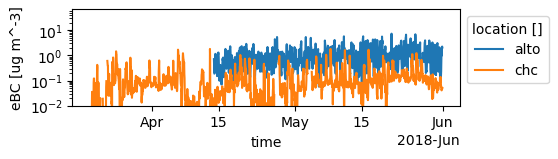

In [56]:
#| label: fig-ts-bc
#| fig-cap: "Timeseries of eBC mass concentration."

(
    ds1['eBC']
    .plot(
        yscale='log',  # Set y-axis to logarithmic scale
        ylim=(1e-2, None),
        # Set lower limit for y-axis, upper limit auto-adjusts
        hue='loc'  # Differentiate data by location
    )
);
ax = plt.gca()
ax.get_legend().set_bbox_to_anchor([1,1])
ax.set_ylabel('eBC [ug m^-3]')

f:plt.Figure = plt.gcf()
_s = 5;f.set_size_inches(_s,_s/4)


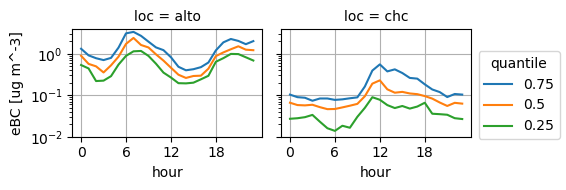

In [62]:
#| label: fig-bc-diurnal
#| fig-cap: “Diurnal median eBC mass concentration with 0.25 and 0.75 quantiles. Notice the y-label in logscale”

res = (
    ds1['eBC']
    .assign_coords({'hour': lambda d: d['time'].dt.hour})
    # Extract and assign hour from time
    .groupby('hour').quantile([.75,.5,.25])
    # Compute 25th, 50th (median), and 75th percentiles per hour
    .plot(
        x='hour',  # Set x-axis to hour
        yscale='log',  # Use logarithmic scale for y-axis
        ylim=(1e-2, None),
        # Set lower limit for y-axis, upper limit auto-adjusts
        col='loc',  # Separate plots by location
        hue='quantile',
        # Differentiate quantiles with colors

        size = 2
    )
)

# Customize axis settings for each subplot
for ax in res.axs.flat:
    ax: plt.Axes
    ax.set_xticks([0, 6, 12, 18])  # Set specific x-axis ticks
    ax.grid()  # Enable grid

res.axs[0,0].set_ylabel('eBC [ug m^-3]'); # Set ylabel on left ax


## Link to references

Some studies that have been published about CHC that can help you interpret your answers

- **New particle formation dynamics in the central Andes: contrasting urban and mountaintop environments** (2025)
  - Authors: Aliaga, D., Sinclair, V. A., Krejci, R., Andrade, M., Artaxo, P., Blacutt, L., Cai, R., Carbone, S., Gramlich, Y., Heikkinen, L., Heslin-Rees, D., Huang, W., Kerminen, V.-M., Koenig, A. M., Kulmala, M., Laj, P., Mardoñez-Balderrama, V., Mohr, C., Moreno, I., Paasonen, P., Scholz, W., Sellegri, K., Ticona, L., Uzu, G., Velarde, F., Wiedensohler, A., Worsnop, D., Wu, C., Xuemeng, C., Zha, Q., and Bianchi, F.
  - Journal: Aerosol Research, 3, 15–44
  - DOI: [10.5194/ar-3-15-2025](https://doi.org/10.5194/ar-3-15-2025)

- **Atmospheric black carbon in the metropolitan area of La Paz and El Alto, Bolivia: concentration levels and emission sources** (2024)
  - Authors: Mardoñez-Balderrama, V., Močnik, G., Pandolfi, M., Modini, R. L., Velarde, F., Renzi, L., Marinoni, A., Jaffrezo, J.-L., Moreno R., I., Aliaga, D., Bianchi, F., Mohr, C., Gysel-Beer, M., Ginot, P., Krejci, R., Wiedensohler, A., Uzu, G., Andrade, M., and Laj, P.
  - Journal: Atmospheric Chemistry and Physics, 24, 12055–12077
  - DOI: [10.5194/acp-24-12055-2024](https://doi.org/10.5194/acp-24-12055-2024)

- **Oxidized organic molecules in the tropical free troposphere over Amazonia** (2023)
  - Authors: Zha, Q., Aliaga, D., Krejci, R., Sinclair, V. A., Wu, C., Ciarelli, G., Scholz, W., Heikkinen, L., Partoll, E., Gramlich, Y., Huang, W., Leiminger, M., Enroth, J., Peräkylä, O., Cai, R., Chen, X., Koenig, A. M., Velarde, F., Moreno, I., Petäjä, T., Artaxo, P., Laj, P., Hansel, A., Carbone, S., Kulmala, M., Andrade, M., Worsnop, D., Mohr, C., and Bianchi, F.
  - Journal: National Science Review, nwad138
  - DOI: [10.1093/nsr/nwad138](https://doi.org/10.1093/nsr/nwad138)

- **The SALTENA Experiment: Comprehensive Observations of Aerosol Sources, Formation, and Processes in the South American Andes** (2022)
  - Authors: Bianchi, F., Sinclair, V. A., Aliaga, D., Zha, Q., Scholz, W., Wu, C., Heikkinen, L., Modini, R., Partoll, E., Velarde, F., Moreno, I., Gramlich, Y., Huang, W., Koenig, A. M., Leiminger, M., Enroth, J., Peräkylä, O., Marinoni, A., Xuemeng, C., Blacutt, L., Forno, R., Gutierrez, R., Ginot, P., Uzu, G., Facchini, M. C., Gilardoni, S., Gysel-Beer, M., Cai, R., Petäjä, T., Rinaldi, M., Saathoff, H., Sellegri, K., Worsnop, D., Artaxo, P., Hansel, A., Kulmala, M., Wiedensohler, A., Laj, P., Krejci, R., Carbone, S., Andrade, M., and Mohr, C.
  - Journal: Bulletin of the American Meteorological Society, 103, E212–E229
  - DOI: [10.1175/BAMS-D-20-0187.1](https://doi.org/10.1175/BAMS-D-20-0187.1)

- **Source apportionment study on particulate air pollution in two high-altitude Bolivian cities: La Paz and El Alto** (2022)
  - Authors: Mardoñez, V., Pandolfi, M., Borlaza, L. J. S., Jaffrezo, J.-L., Alastuey, A., Besombes, J.-L., Moreno R., I., Perez, N., Močnik, G., Ginot, P., Krejci, R., Chrastny, V., Wiedensohler, A., Laj, P., Andrade, M., and Uzu, G.
  - Journal: Atmospheric Chemistry and Physics Discussions, 1–41
  - DOI: [10.5194/acp-2022-780](https://doi.org/10.5194/acp-2022-780)

- **Identifying source regions of air masses sampled at the tropical high-altitude site of Chacaltaya using WRF-FLEXPART and cluster analysis** (2021)
  - Authors: Aliaga, D., Sinclair, V. A., Andrade, M., Artaxo, P., Carbone, S., Kadantsev, E., Laj, P., Wiedensohler, A., Krejci, R., and Bianchi, F.
  - Journal: Atmospheric Chemistry and Physics, 21, 16453–16477
  - DOI: [10.5194/acp-21-16453-2021](https://doi.org/10.5194/acp-21-16453-2021)

- **Black carbon emission and transport mechanisms to the free troposphere at the La Paz/El Alto (Bolivia) metropolitan area based on the Day of Census (2012)** (2018)
  - Authors: Wiedensohler, A., Andrade, M., Weinhold, K., Müller, T., Birmili, W., Velarde, F., Moreno, I., Forno, R., Sanchez, M. F., Laj, P., Ginot, P., Whiteman, D. N., Krejci, R., Sellegri, K., and Reichler, T.
  - Journal: Atmospheric Environment, 194, 158–169
  - DOI: [10.1016/j.atmosenv.2018.09.032](https://doi.org/10.1016/j.atmosenv.2018.09.032)